### Introduction

How much is an hour of work worth? It depends. It depends on so many factors that it would make this problem unfeasable for an undergrad with a laptop. (Un)fortunately that kind of information is unavailable, so I will build a simpler model that will try to predict an employee's salary based on their name, the job's title, and other attributes derived from those two. 

This is an NLP problem

#### Dependencies

In [2]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

### Data information

#### Data description

In [8]:
df = pd.read_csv(r"data/Salaries.csv", header=0, delimiter=',')

/home/carlos/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (3,4,5,6,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
df.head()

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,Notes,Agency,Status
0,1,NATHANIEL FORD,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411.18,0.0,400184.25,NaN,567595.43,567595.43,2011,NaN,San Francisco,NaN
1,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966.02,245131.88,137811.38,NaN,538909.28,538909.28,2011,NaN,San Francisco,NaN
2,3,ALBERT PARDINI,CAPTAIN III (POLICE DEPARTMENT),212739.13,106088.18,16452.6,NaN,335279.91,335279.91,2011,NaN,San Francisco,NaN
3,4,CHRISTOPHER CHONG,WIRE ROPE CABLE MAINTENANCE MECHANIC,77916.0,56120.71,198306.9,NaN,332343.61,332343.61,2011,NaN,San Francisco,NaN
4,5,PATRICK GARDNER,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",134401.6,9737.0,182234.59,NaN,326373.19,326373.19,2011,NaN,San Francisco,NaN


In [4]:
df.describe()

,Id,TotalPay,TotalPayBenefits,Year,Notes
count,148654.000000,148654.000000,148654.000000,148654.000000,0.0
mean,74327.500000,74768.321972,93692.554811,2012.522643,NaN
std,42912.857795,50517.005274,62793.533483,1.117538,NaN
min,1.000000,-618.130000,-618.130000,2011.000000,NaN
25%,37164.250000,36168.995000,44065.650000,2012.000000,NaN
50%,74327.500000,71426.610000,92404.090000,2013.000000,NaN
75%,111490.750000,105839.135000,132876.450000,2014.000000,NaN
max,148654.000000,567595.430000,567595.430000,2014.000000,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148654 entries, 0 to 148653
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Id                148654 non-null  int64  
 1   EmployeeName      148654 non-null  object 
 2   JobTitle          148654 non-null  object 
 3   BasePay           148049 non-null  object 
 4   OvertimePay       148654 non-null  object 
 5   OtherPay          148654 non-null  object 
 6   Benefits          112495 non-null  object 
 7   TotalPay          148654 non-null  float64
 8   TotalPayBenefits  148654 non-null  float64
 9   Year              148654 non-null  int64  
 10  Notes             0 non-null       float64
 11  Agency            148654 non-null  object 
 12  Status            38119 non-null   object 
dtypes: float64(3), int64(2), object(8)
memory usage: 14.7+ MB


#### Data clean up

We could start by dropping the 'Id' column because it adds no information to any employee, and the'Notes' column, since it only has null values. Then we took a look at 'Agency' and found out that the only value is 'San Francisco', so that one could be dropped as well. We also thought that since there are south of 1000 'BasePay' null values, we could delete those rows without hesitation.

<AxesSubplot:>

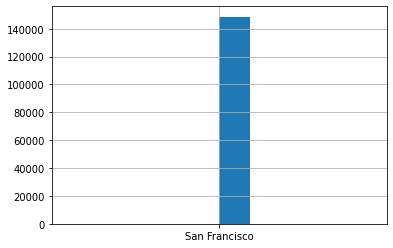

In [6]:
df.Agency.hist()

In [7]:
df = df.drop(['Notes', 'Agency', 'Id', 'Status'], axis=1)
df = df[df.BasePay.notnull()]

After that, we wondered why some columns such as 'BasePay', 'OvertimePay', 'OtherPay' or 'Benefits' had an object data type. We discovered that 4 entries have value 'Not provided'. Since those rows gave us absolutely no data, we dropped them and changed the data types.

In [8]:
df['BasePay'].eq('Not Provided').sum()

4

In [9]:
df = df[df.BasePay.ne('Not Provided')]

In [10]:
df.BasePay = df.BasePay.astype('float64')
df.OvertimePay = df.OvertimePay.astype('float64')
df.OtherPay = df.OtherPay.astype('float64')
df.Benefits = df.Benefits.astype('float64')

As per 'Benefits', we saw that some 40k entries have a null value: those are way too many to drop, so we thought that maybe when 'Benefits' is null, then it means there were no benefits, so 'TotalPayBenefits' should be equal to 'TotalPay'. After proving it right, we set all null values in 'Benefits' to 0.

In [11]:
(df.TotalPay[df.Benefits.isnull()] == df.TotalPayBenefits[df.Benefits.isnull()]).all()

True

In [12]:
df.loc[df.Benefits.isnull(), 'Benefits'] = 0

We also thought that it didn't make much sense to have negative salaries, or any kind of pay, so they are going to be dropped. The reason for a negative salary might be related to a compensation due to a scheduling error.

In [13]:
df = df[df.iloc[:, np.array([df.dtypes == 'float64']).reshape(df.shape[1], )].ge(0).all(axis=1)]
df = df.reset_index(drop=True)

Now the data is pretty clean, but we thought it would be a good idea to have every 'JobTitle' in uppercase letters, and to delete all extra spaces which could mess up some string comprehension we might take on later.

In [14]:
df.JobTitle = df.JobTitle.str.upper()
df.JobTitle = df.JobTitle.replace(to_replace=r'  +', value=' ', regex=True)
df.EmployeeName = df.EmployeeName.str.upper()
df.EmployeeName = df.EmployeeName.replace(to_replace=r'  +', value=' ', regex=True)

In [15]:
df.describe()

,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year
count,148027.000000,148027.000000,148027.000000,148027.000000,148027.000000,148027.000000,148027.000000
mean,66331.428168,5087.334185,3646.079395,18981.854008,75064.841748,94046.695756,2012.520655
std,42762.323488,11473.751595,8019.832754,17176.358349,50407.656154,62680.706812,1.119432
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2011.000000
25%,33599.910000,0.000000,0.000000,0.000000,36989.785000,45100.210000,2012.000000
50%,65010.820000,0.000000,817.590000,23471.230000,71649.200000,92680.690000,2013.000000
75%,94691.060000,4696.820000,4243.500000,33508.710000,106031.075000,133096.950000,2014.000000
max,319275.010000,245131.880000,400184.250000,96570.660000,567595.430000,567595.430000,2014.000000


### Data analysis

#### Salary classification

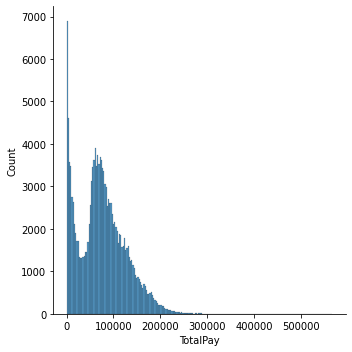

In [16]:
sns.displot(df.TotalPay)

It has multimodal distribution, so we split the data around the anual minimum wage for a full time job, which was around 21k a year.

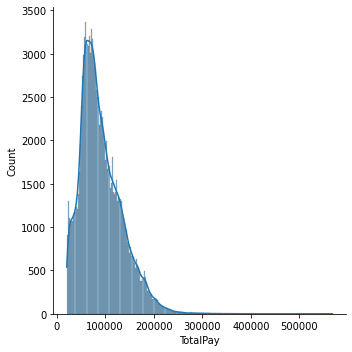

In [17]:
sns.displot(df.TotalPay[df.BasePay > 2.1e4], kde=True)

It becomes more gaussian-y, although it is still right-tailed.

Let's check out the other part now.

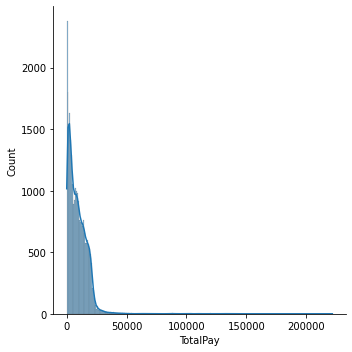

In [18]:
sns.displot(df.TotalPay[df.BasePay < 2.1e4], kde=True)

It's not gaussian at all: we can't even see it properly, but there are a few employees with a lower than minimum wage base salary but still end up making north of 200k, so its over 9 times their base salary in overtime pay (or other pay). Could those be fire fighters pulling 14 hour shifts or world known surgeons performing almost impossible operations?

In [19]:
df.iloc[df.TotalPay[df.BasePay < 2.1e4].sort_values().index[-15:]].JobTitle

46090                           LIEUTENANT 3
120246                             CAPTAIN 3
3488      LIEUTENANT III (POLICE DEPARTMENT)
3263                              MANAGER VI
2896                             MANAGER VII
81541                       POLICE OFFICER 3
118992        CHIEF ATTY1 (CIVIL & CRIMINAL)
43797              CAPTAIN, FIRE SUPPRESSION
1887      INSPECTOR III, (POLICE DEPARTMENT)
113146               SENIOR MUSEUM REGISTRAR
1669      INSPECTOR III, (POLICE DEPARTMENT)
39843                            INSPECTOR 3
40140         BATTLION CHIEF, FIRE SUPPRESSI
39613               ASSISTANT DEPUTY CHIEF 2
36888         CHIEF ATTY1 (CIVIL & CRIMINAL)
Name: JobTitle, dtype: object

We can see no doctors, but we do see police officers, fire fighters, attorneys some general managers and a very good museum registrar.

Since the full time jobs year round look so much more promising than the others, we'll start with those.

In [20]:
df = df[df.BasePay > 2.1e4]

#### Job classification

In [21]:
def add_classification(df, column, new_column, keywords):
    for classification in keywords.keys():
        for keyword in keywords[classification]:
            df.loc[df[column].str.contains(keyword), new_column] = classification

In [22]:
unique_jobs, idx_jobs, cn_jobs = np.unique(df.JobTitle, return_index=True, return_counts=True)
unique_jobs[np.argsort(cn_jobs)][::-1][:20]

array(['TRANSIT OPERATOR', 'REGISTERED NURSE', 'FIREFIGHTER', 'CUSTODIAN',
       'SPECIAL NURSE', 'DEPUTY SHERIFF', 'POLICE OFFICER 3',
       'ATTORNEY (CIVIL/CRIMINAL)', 'PATIENT CARE ASSISTANT',
       'POLICE OFFICER', 'GENERAL LABORER', 'PORTER', 'POLICE OFFICER 2',
       'GARDENER', 'PARKING CONTROL OFFICER', 'SERGEANT 3',
       'SENIOR CLERK TYPIST', 'EMT/PARAMEDIC/FIREFIGHTER', 'SENIOR CLERK',
       'SENIOR ELIGIBILITY WORKER'], dtype=object)

In [23]:
sorted_cn_jobs = np.array(sorted(cn_jobs, reverse=True))

In [24]:
print(sorted_cn_jobs[sorted_cn_jobs > 500].sum())
print(sorted_cn_jobs[sorted_cn_jobs > 500].shape)

52829
(39,)


In [25]:
df = df[df.JobTitle.isin(unique_jobs[np.argsort(cn_jobs)][::-1][:39])].reset_index(drop=True)

In [26]:
job_classification = {'FIRE': ['FIRE'],
                     'POLICE': ['POLICE', 'SHERIF', 'PROBATION', 'SERGEANT', 'FORENSIC'],
                     'TRANSIT': ['TRANSIT', 'MTA', 'TRANSPORT', 'TRAF'],
                     'MEDICAL': ['MEDICAL', 'ANESTH',  'NURS', 'HEALTH', 'ORTHOPEDIC', 'PHYSICIAN', 'HEALTH', 'PHARM', 'DIAGNOSTIC', 'PSYCH', 'SURG', 'HOSPITAL', 'DENTAL', 'THERAP', 'EPIDEM', 'DISEASE', 'BACTER'],
                     'AIRPORT': ['AIRPORT'],
                     'ANIMAL': ['ANIMAL'],
                     'ARCHITECTURAL': ['ARCHITECT'],
                     'COURT': ['COURT', 'LEGAL', 'COUNSELOR', 'LAW', 'FISCAL'],
                     'MAYOR': ['MAYOR'],
                     'LIBRARY': ['LIBRAR'],
                     'PARKING': ['PARKING'],
                     'PUBLIC WORKS': ['PUBLIC WORKS', 'BUILD', 'CEMENT', 'BRICK'],
                     'ATTORNEY': ['ATTORNEY'],
                     'AUTOMOTIVE': ['AUTOMOTIVE', 'CAR '],
                     'CUSTODIAN': ['CUSTODIAN'],
                     'ENGINEER': ['ENGINEER', 'ENGR', 'ENG'],
                     'ACCOUNTING': ['ACCOUNT'],
                     'GARDENER': ['GARDEN', 'TREE', 'FOREST'],
                     'GENERAL LABORER': ['GENERAL LABORER', 'PLUM ', 'MECHANIC', 'ELECTRICIAN', 'REPAIRER', 'PAINTER', 'CARPENTER', 'CLEANER'],
                     'FOOD SERVICE': ['FOOD SERV'],
                     'CLERK': ['CLERK'],
                     'PORTER': ['PORTER'],
                     'PORT': ['PORT '],
                     'GUARD': ['GUARD'],
                     'HUMAN RESOURCES': ['HUMAN']}

In [27]:
add_classification(df, 'JobTitle', 'JobArea', job_classification)

#### Gender classification

In [28]:
womens_names = pd.read_csv(r"babies-first-names-top-100-girls.csv", header=0, delimiter=',')
mens_names = pd.read_csv(r"babies-first-names-top-100-boys.csv", header=0, delimiter=',')

In [29]:
womens_names.FirstForename = womens_names.FirstForename.str.upper()
mens_names.FirstForename = mens_names.FirstForename.str.upper()

In [30]:
gender_classification = {'F': womens_names.FirstForename.to_list(),
                        'M': mens_names.FirstForename.to_list()}

In [31]:
df.loc[:, 'FirstName'] = df.EmployeeName.apply(lambda x: ''.join(x.split()[0]))

In [32]:
add_classification(df, 'FirstName', 'Gender', gender_classification)

#### Ranking classification

In [33]:
ranking_classification = {'LOW': [''],
                          'HIGH': ['SENIOR', 'MANAGER', 'III', 'IV', ' V', 'VI', 'CHIEF', 'HEAD', 'DIRECTOR', 'SUPERVISOR', 'CAPTAIN', 'LIEUTENANT', 'SERGEANT']}

In [34]:
add_classification(df, 'JobTitle', 'Ranking', ranking_classification)

In [35]:
df

,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,JobArea,FirstName,Gender,Ranking
0,MICHAEL THOMPSON,FIREFIGHTER,123013.02,111729.65,15575.26,0.00,250317.93,250317.93,2011,FIRE,MICHAEL,M,LOW
1,EVETTE GEER-STEVENS,TRANSIT SUPERVISOR,88062.00,135159.38,7018.60,0.00,230239.98,230239.98,2011,TRANSIT,EVETTE,F,HIGH
2,LAUIFI SEUMAALA,FIREFIGHTER,105934.69,98534.35,18890.96,0.00,223360.00,223360.00,2011,FIRE,LAUIFI,NaN,LOW
3,EDWARD DENNIS,TRANSIT SUPERVISOR,88400.70,126778.88,7228.67,0.00,222408.25,222408.25,2011,TRANSIT,EDWARD,M,HIGH
4,PATRIC STEELE,FIREFIGHTER,105934.64,97395.59,18760.77,0.00,222091.00,222091.00,2011,FIRE,PATRIC,NaN,LOW
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52824,BOB MASSOLA,POLICE OFFICER 3,21721.76,0.00,0.00,217.22,21721.76,21938.98,2014,POLICE,BOB,NaN,LOW
52825,AMORITA C UPERESA,PORTER,21504.11,0.00,0.00,215.03,21504.11,21719.14,2014,PORTER,AMORITA,NaN,LOW
52826,MARIANO R FLORES,SPECIAL NURSE,21717.50,0.00,0.00,0.00,21717.50,21717.50,2014,MEDICAL,MARIANO,M,LOW
52827,JOSALIZA D SILLA,PATIENT CARE ASSISTANT,21292.15,0.00,115.56,214.08,21407.71,21621.79,2014,NaN,JOSALIZA,NaN,LOW


#### Model creation

In [36]:
df = df[df.JobArea.notna() * df.Gender.notna()]
df.shape

(25074, 13)

In [38]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df.JobTitle)

In [39]:
similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [40]:
def get_index(job, column, df):
    if (df[column] == job).any():
        return df[df[column] == job].index[0]
    else:
        return None

def predict(job, column, df):
    index =  job
    index = get_index(job, column, df)
    if index is None:
        raise ValueError('Invalid ' + column + ' name')
    
    job_similarities = list(enumerate(similarities[index]))
    job_similarities = sorted(job_similarities, key=lambda x: x[1], reverse=True)
    job_similarities = [job[0] for job in job_similarities if job[1] > 0.8]
    return df.iloc[job_similarities[1:]].TotalPay.mean()

In [45]:
predict('F', 'Gender', df)

109844.78290666666

In [51]:
predict('M', 'Gender', df)

145197.8995675413

In [54]:
predict('PETER', 'FirstName', df)

129379.89881091619

In [56]:
predict('POLICE OFFICER', 'JobTitle', df)

115814.80731501056

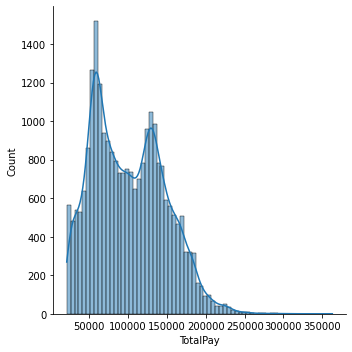

In [50]:
sns.displot(df.TotalPay, kde=True)